
Summary Statistics:
1. Total number of chats: 4,959
2. Total code suggestions: 26,734
3. Total code acceptances: 7,943
4. Overall acceptance rate: 29.71%
5. Number of unique languages: 28
6. Total lines suggested: 66,891
7. Total lines accepted: 12,112
8. Overall lines acceptance rate: 18.11%



<Figure size 1500x600 with 0 Axes>

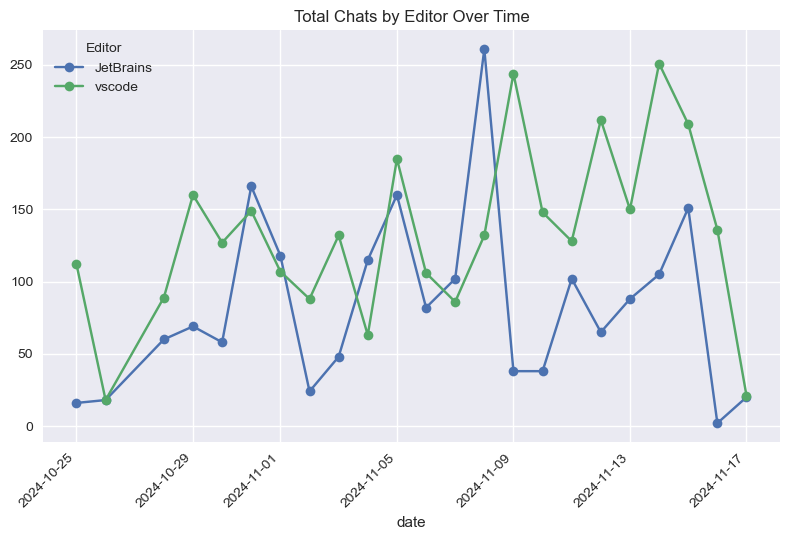

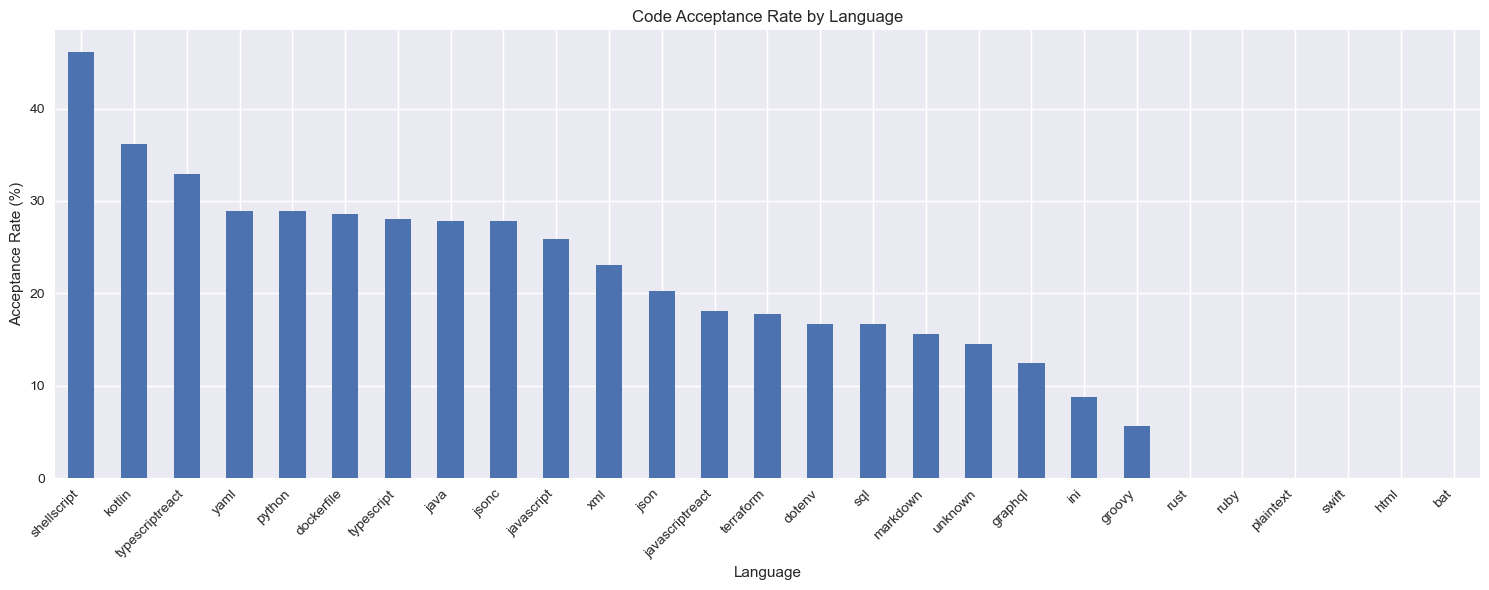

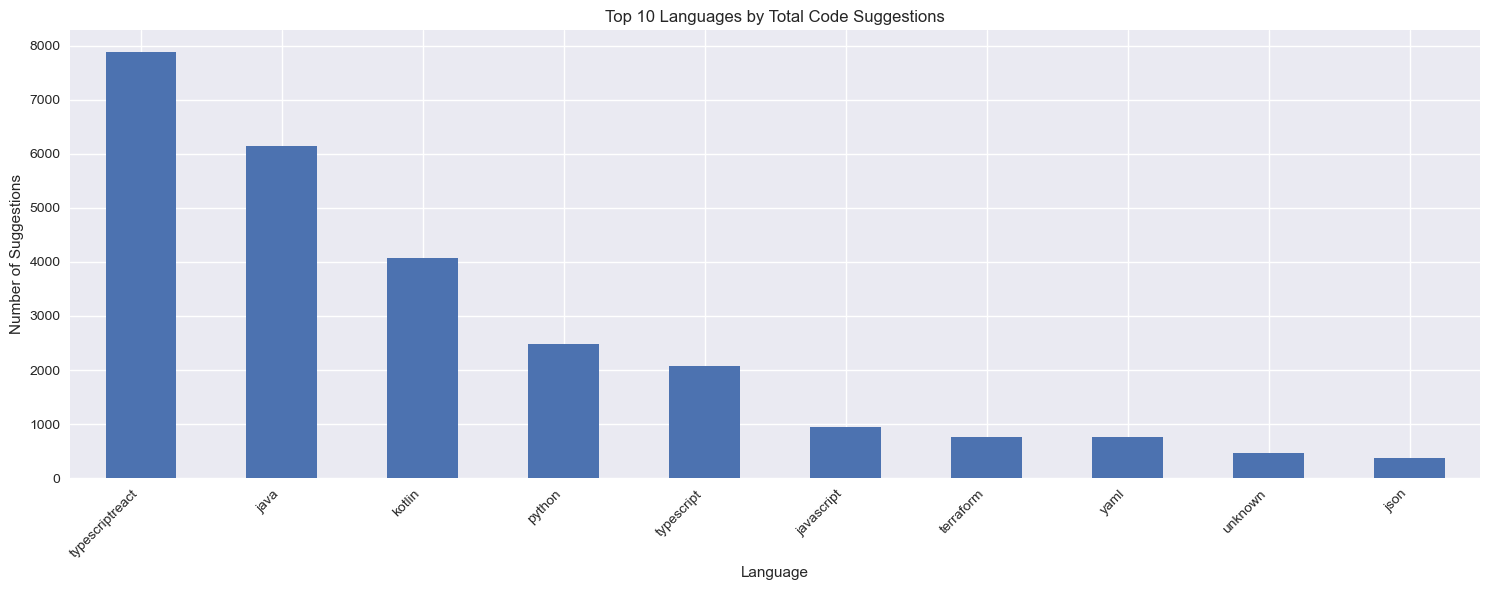

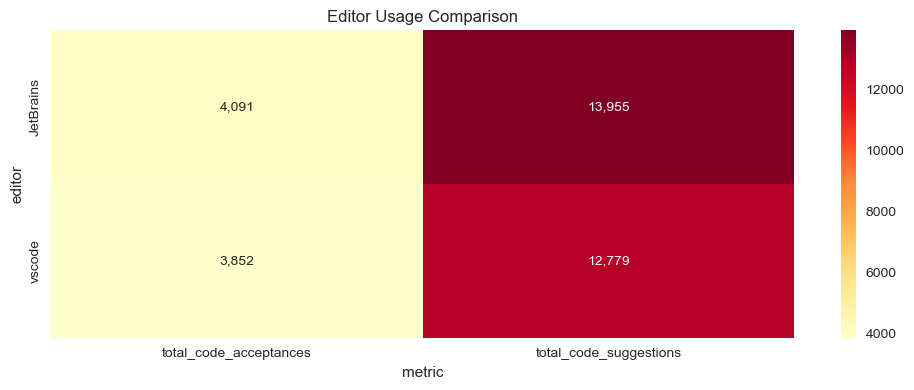

<Figure size 1500x600 with 0 Axes>

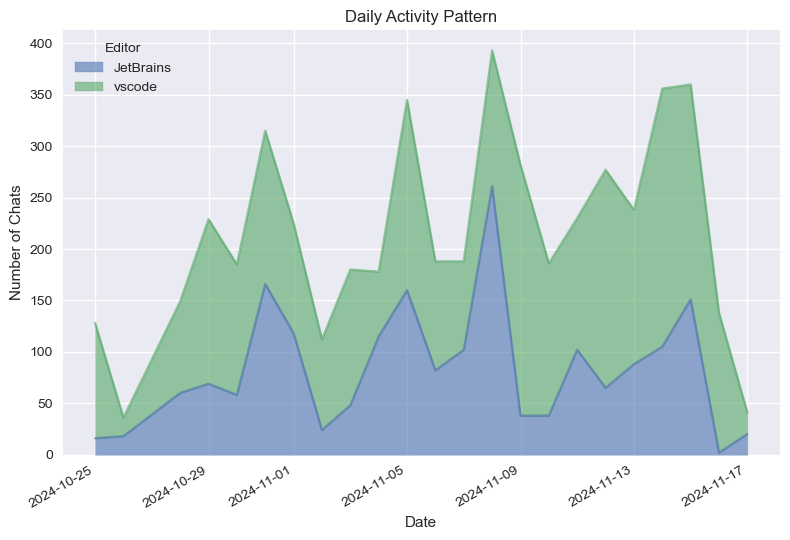

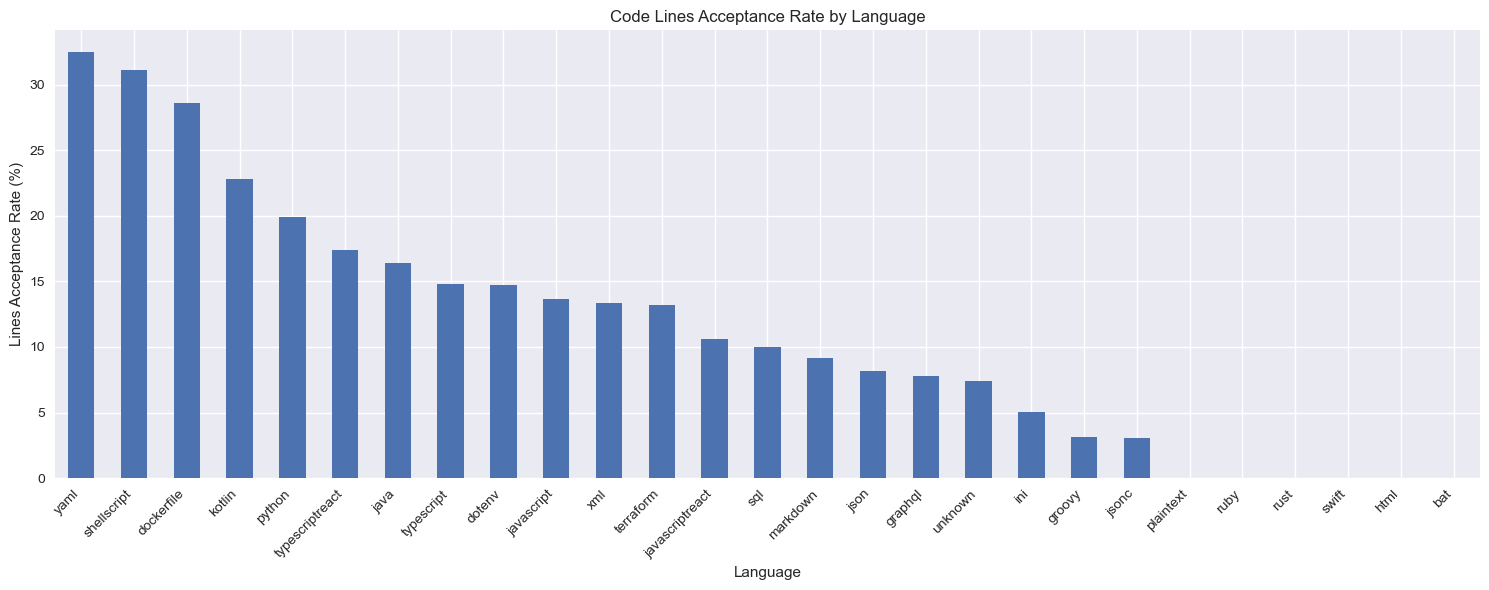

<Figure size 1500x600 with 0 Axes>

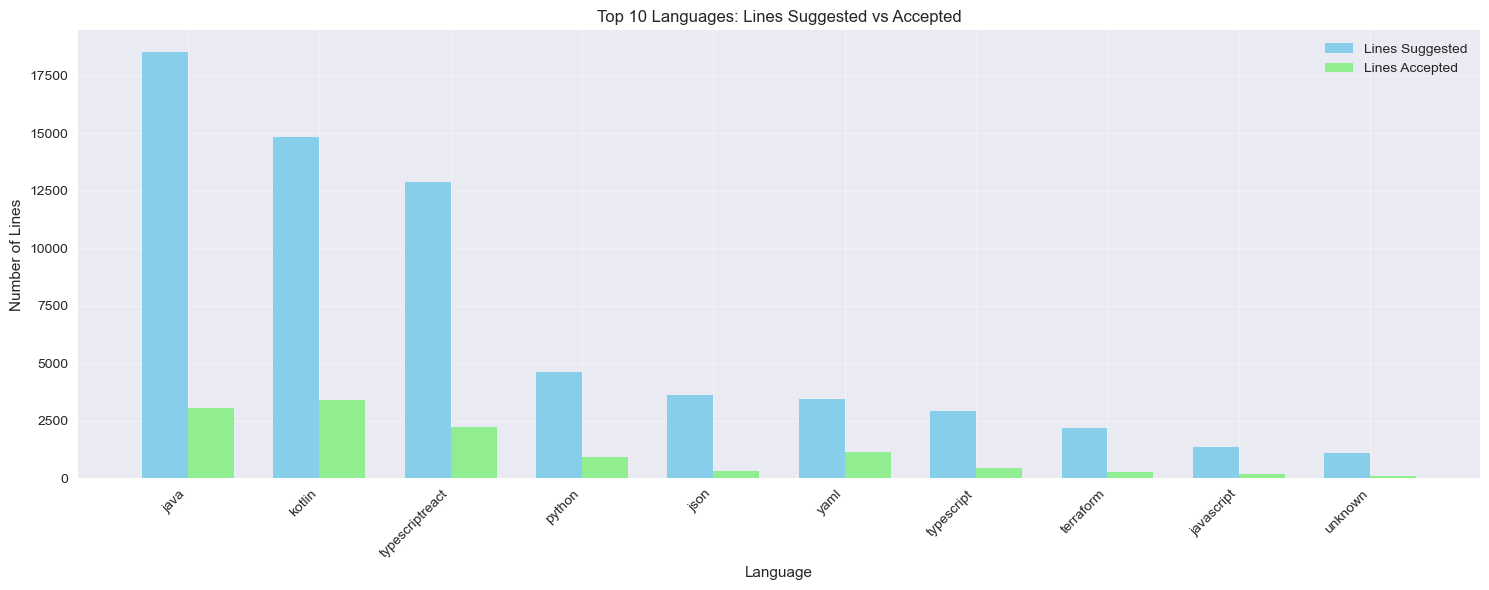

<Figure size 1500x600 with 0 Axes>

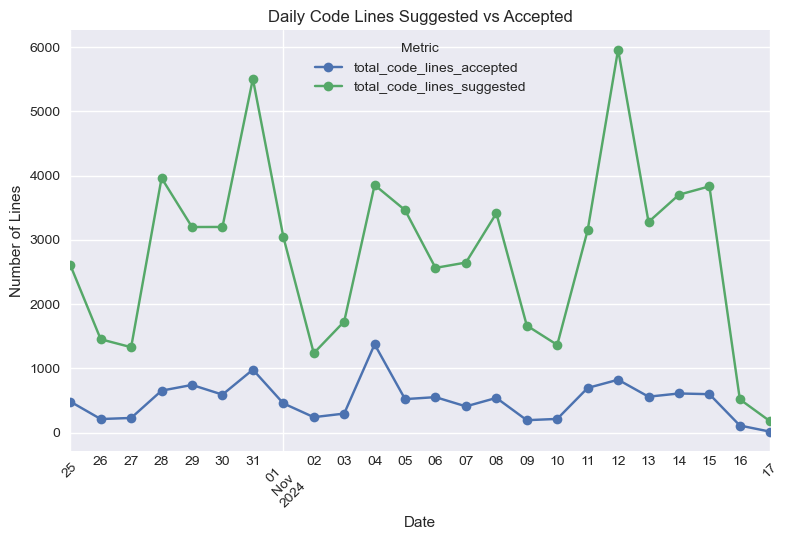

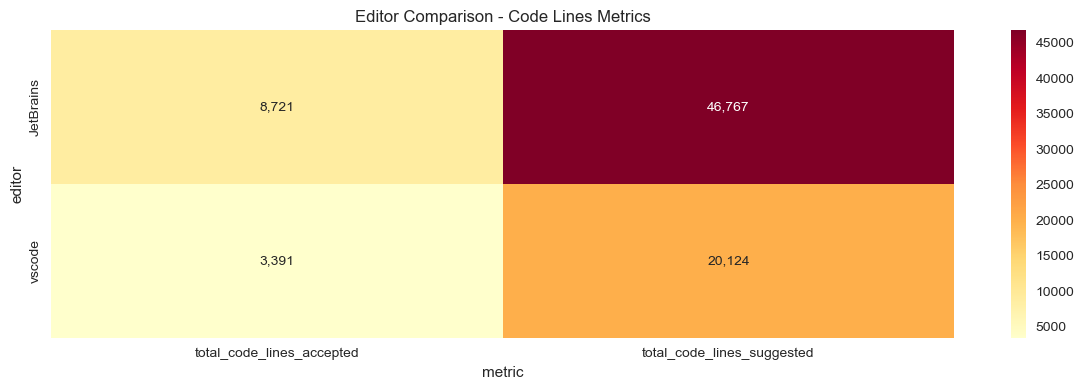

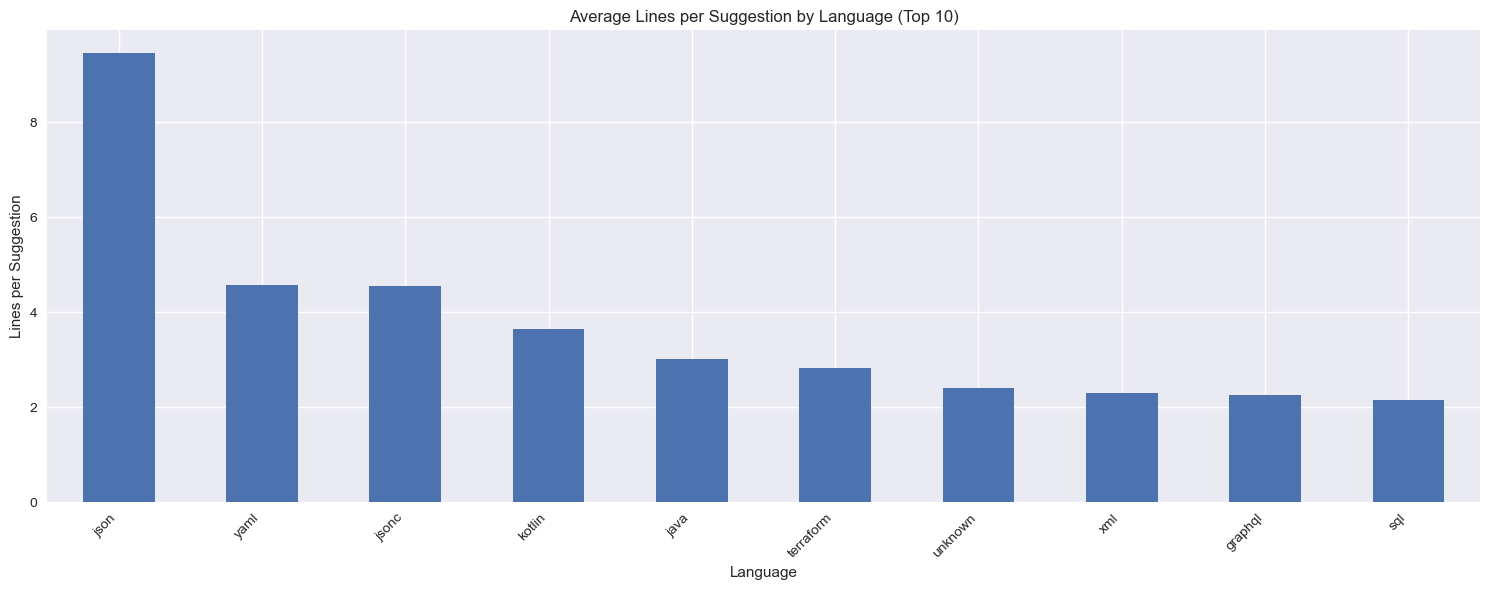

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json

# Read the JSON data
with open('output.json', 'r') as file:
    json_data = json.load(file)

# Process the data into a format similar to the CSV
records = []

for entry in json_data:
    date = entry['date']
    
    # Process chat data
    if 'copilot_ide_chat' in entry and 'editors' in entry['copilot_ide_chat']:
        for editor in entry['copilot_ide_chat']['editors']:
            for model in editor['models']:
                records.append({
                    'date': date,
                    'editor': editor['name'],
                    'model': model['name'],
                    'metric': 'total_chats',
                    'value': model['total_chats'],
                    'language': ''
                })

    # Process code completion data
    if 'copilot_ide_code_completions' in entry and 'editors' in entry['copilot_ide_code_completions']:
        for editor in entry['copilot_ide_code_completions']['editors']:
            for model in editor['models']:
                if 'languages' in model:
                    for lang in model['languages']:
                        if 'total_code_suggestions' in lang:
                            records.append({
                                'date': date,
                                'editor': editor['name'],
                                'model': model['name'],
                                'metric': 'total_code_suggestions',
                                'value': lang['total_code_suggestions'],
                                'language': lang['name']
                            })
                        if 'total_code_acceptances' in lang:
                            records.append({
                                'date': date,
                                'editor': editor['name'],
                                'model': model['name'],
                                'metric': 'total_code_acceptances',
                                'value': lang['total_code_acceptances'],
                                'language': lang['name']
                            })
                        if 'total_code_lines_suggested' in lang:
                            records.append({
                                'date': date,
                                'editor': editor['name'],
                                'model': model['name'],
                                'metric': 'total_code_lines_suggested',
                                'value': lang['total_code_lines_suggested'],
                                'language': lang['name']
                            })
                        if 'total_code_lines_accepted' in lang:
                            records.append({
                                'date': date,
                                'editor': editor['name'],
                                'model': model['name'],
                                'metric': 'total_code_lines_accepted',
                                'value': lang['total_code_lines_accepted'],
                                'language': lang['name']
                            })

# Create DataFrame
df = pd.DataFrame(records)
df['date'] = pd.to_datetime(df['date'])

# Set the style for all plots
plt.style.use('seaborn')

# 1. Total Chats by Editor Over Time
plt.figure(figsize=(15, 6))
chat_data = df[df['metric'] == 'total_chats'].pivot(index='date', columns='editor', values='value')
chat_data.plot(marker='o')
plt.title('Total Chats by Editor Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title='Editor')
plt.tight_layout()

# 2. Code Acceptance Rate by Language
code_suggestions = df[df['metric'] == 'total_code_suggestions'].groupby('language')['value'].sum()
code_acceptances = df[df['metric'] == 'total_code_acceptances'].groupby('language')['value'].sum()
acceptance_rate = (code_acceptances / code_suggestions * 100).round(2)

plt.figure(figsize=(15, 6))
acceptance_rate.sort_values(ascending=False).plot(kind='bar')
plt.title('Code Acceptance Rate by Language')
plt.xlabel('Language')
plt.ylabel('Acceptance Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()

# 3. Top Languages by Total Code Suggestions
plt.figure(figsize=(15, 6))
total_suggestions = df[df['metric'] == 'total_code_suggestions'].groupby('language')['value'].sum()
total_suggestions.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 Languages by Total Code Suggestions')
plt.xlabel('Language')
plt.ylabel('Number of Suggestions')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()

# 4. Editor Usage Comparison (Heatmap)
pivot_data = df[df['metric'].isin(['total_code_suggestions', 'total_code_acceptances'])].pivot_table(
    index='editor',
    columns='metric',
    values='value',
    aggfunc='sum'
)

plt.figure(figsize=(10, 4))
sns.heatmap(pivot_data, annot=True, fmt=',d', cmap='YlOrRd')
plt.title('Editor Usage Comparison')
plt.tight_layout()

# 5. Daily Activity Pattern
daily_activity = df[df['metric'] == 'total_chats'].groupby(['date', 'editor'])['value'].sum().unstack()
plt.figure(figsize=(15, 6))
daily_activity.plot(kind='area', stacked=True, alpha=0.6)
plt.title('Daily Activity Pattern')
plt.xlabel('Date')
plt.ylabel('Number of Chats')
plt.grid(True)
plt.legend(title='Editor')
plt.tight_layout()

# 6. Code Lines Acceptance Rate by Language
plt.figure(figsize=(15, 6))
lines_suggested = df[df['metric'] == 'total_code_lines_suggested'].groupby('language')['value'].sum()
lines_accepted = df[df['metric'] == 'total_code_lines_accepted'].groupby('language')['value'].sum()
lines_acceptance_rate = (lines_accepted / lines_suggested * 100).round(2)

lines_acceptance_rate.sort_values(ascending=False).plot(kind='bar')
plt.title('Code Lines Acceptance Rate by Language')
plt.xlabel('Language')
plt.ylabel('Lines Acceptance Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()

# 7. Top Languages by Total Lines Suggested vs Accepted
plt.figure(figsize=(15, 6))
total_lines_suggested = df[df['metric'] == 'total_code_lines_suggested'].groupby('language')['value'].sum()
total_lines_accepted = df[df['metric'] == 'total_code_lines_accepted'].groupby('language')['value'].sum()

# Create a grouped bar chart
x = range(len(total_lines_suggested.head(10)))
width = 0.35

fig, ax = plt.subplots(figsize=(15, 6))
suggested_bars = ax.bar([i - width/2 for i in x], total_lines_suggested.sort_values(ascending=False).head(10), 
                       width, label='Lines Suggested', color='skyblue')
accepted_bars = ax.bar([i + width/2 for i in x], total_lines_accepted[total_lines_suggested.sort_values(ascending=False).head(10).index], 
                      width, label='Lines Accepted', color='lightgreen')

plt.title('Top 10 Languages: Lines Suggested vs Accepted')
plt.xlabel('Language')
plt.ylabel('Number of Lines')
plt.xticks(x, total_lines_suggested.sort_values(ascending=False).head(10).index, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# 8. Daily Lines Suggested vs Accepted Trend
plt.figure(figsize=(15, 6))
daily_lines = df[df['metric'].isin(['total_code_lines_suggested', 'total_code_lines_accepted'])].groupby(['date', 'metric'])['value'].sum().unstack()
daily_lines.plot(marker='o')
plt.title('Daily Code Lines Suggested vs Accepted')
plt.xlabel('Date')
plt.ylabel('Number of Lines')
plt.grid(True)
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.tight_layout()

# 9. Editor Comparison for Lines Metrics (Heatmap)
plt.figure(figsize=(12, 4))
lines_pivot = df[df['metric'].isin(['total_code_lines_suggested', 'total_code_lines_accepted'])].pivot_table(
    index='editor',
    columns='metric',
    values='value',
    aggfunc='sum'
)
sns.heatmap(lines_pivot, annot=True, fmt=',d', cmap='YlOrRd')
plt.title('Editor Comparison - Code Lines Metrics')
plt.tight_layout()

# 10. Lines per Suggestion Ratio by Language
plt.figure(figsize=(15, 6))
lines_per_suggestion = (total_lines_suggested / total_suggestions).sort_values(ascending=False)
lines_per_suggestion.head(10).plot(kind='bar')
plt.title('Average Lines per Suggestion by Language (Top 10)')
plt.xlabel('Language')
plt.ylabel('Lines per Suggestion')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()

# Calculate summary statistics
total_chats = df[df['metric'] == 'total_chats']['value'].sum()
total_suggestions = df[df['metric'] == 'total_code_suggestions']['value'].sum()
total_acceptances = df[df['metric'] == 'total_code_acceptances']['value'].sum()
total_lines_suggested = df[df['metric'] == 'total_code_lines_suggested']['value'].sum()
total_lines_accepted = df[df['metric'] == 'total_code_lines_accepted']['value'].sum()

overall_acceptance_rate = (total_acceptances / total_suggestions * 100) if total_suggestions > 0 else 0
lines_acceptance_rate = (total_lines_accepted / total_lines_suggested * 100) if total_lines_suggested > 0 else 0

# Print summary statistics
summary_stats = f"""
Summary Statistics:
1. Total number of chats: {total_chats:,}
2. Total code suggestions: {total_suggestions:,}
3. Total code acceptances: {total_acceptances:,}
4. Overall acceptance rate: {overall_acceptance_rate:.2f}%
5. Number of unique languages: {df['language'].nunique()}
6. Total lines suggested: {total_lines_suggested:,}
7. Total lines accepted: {total_lines_accepted:,}
8. Overall lines acceptance rate: {lines_acceptance_rate:.2f}%
"""

print(summary_stats)

# Display all plots
plt.show()